캐글 제출용 (인코더 온리)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D, MultiHeadAttention, LayerNormalization, Dropout, TextVectorization, Embedding
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import re

# 1. 데이터 불러오기 및 컬럼명 정리
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv').rename(columns={'text': 'conversation', 'idx': 'file_name'})

# 2. 텍스트 전처리 및 클래스명 통일
def clean_text(text):
    return re.sub(r'\s+', ' ', str(text).strip())

def clean_class(x):
    return x.replace(' ', '').replace('대화', '')

train_df['conversation'] = train_df['conversation'].apply(clean_text)
test_df['conversation'] = test_df['conversation'].apply(clean_text)
train_df['class'] = train_df['class'].apply(clean_class)

# 3. 클래스 매핑
custom_classes = ['협박', '갈취', '직장내괴롭힘', '기타괴롭힘', '일반']
class2idx = {c:i for i,c in enumerate(custom_classes)}
train_df['target'] = train_df['class'].map(class2idx)

# 4. 특수 토큰 추가
train_df['conversation'] = "[CLS] " + train_df['conversation'] + " [SEP]"
test_df['conversation'] = "[CLS] " + test_df['conversation'] + " [SEP]"

# 5. 데이터 분할
X = train_df['conversation'].values.astype(str)
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 6. 텐서 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val = tf.convert_to_tensor(X_val, dtype=tf.string)

# 7. 텍스트 벡터화
VOCAB_SIZE = 20000
MAX_LEN = 128
EMBED_DIM = 128  # 11. 하이퍼파라미터
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)
vectorize_layer.adapt(X_train)

# 8. 트랜스포머 인코더
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(0.3)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    y = Dense(ff_dim, activation="relu")(x)
    y = Dense(inputs.shape[-1])(y)
    y = Dropout(0.3)(y)
    return LayerNormalization(epsilon=1e-6)(x + y)

# 9. 모델 구성
inputs = Input(shape=(), dtype=tf.string)
x = vectorize_layer(inputs)
x = Embedding(VOCAB_SIZE, EMBED_DIM)(x)
x = transformer_encoder(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(len(custom_classes), activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 10. F1-score 콜백
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.f1_scores = []
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_val, verbose=0).argmax(axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        self.f1_scores.append(f1)
        print(f'\nVal F1: {f1:.4f}')

f1_callback = F1Callback()

# 11. 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[f1_callback]
)

# 12. 결과 시각화
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,1,2)
plt.plot(history.history['loss'], 'go-', label='Train Loss')
plt.plot(history.history['val_loss'], 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(f1_callback.f1_scores, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

# 13. 테스트 데이터 예측 및 제출 (컬럼명 idx/target)
X_test = tf.convert_to_tensor(test_df['conversation'].values.astype(str), dtype=tf.string)
y_pred = model.predict(X_test).argmax(axis=1)

submission_5 = pd.DataFrame({
    'idx': test_df['file_name'],
    'target': y_pred
})
submission_5.to_csv('submission_5.csv', index=False)


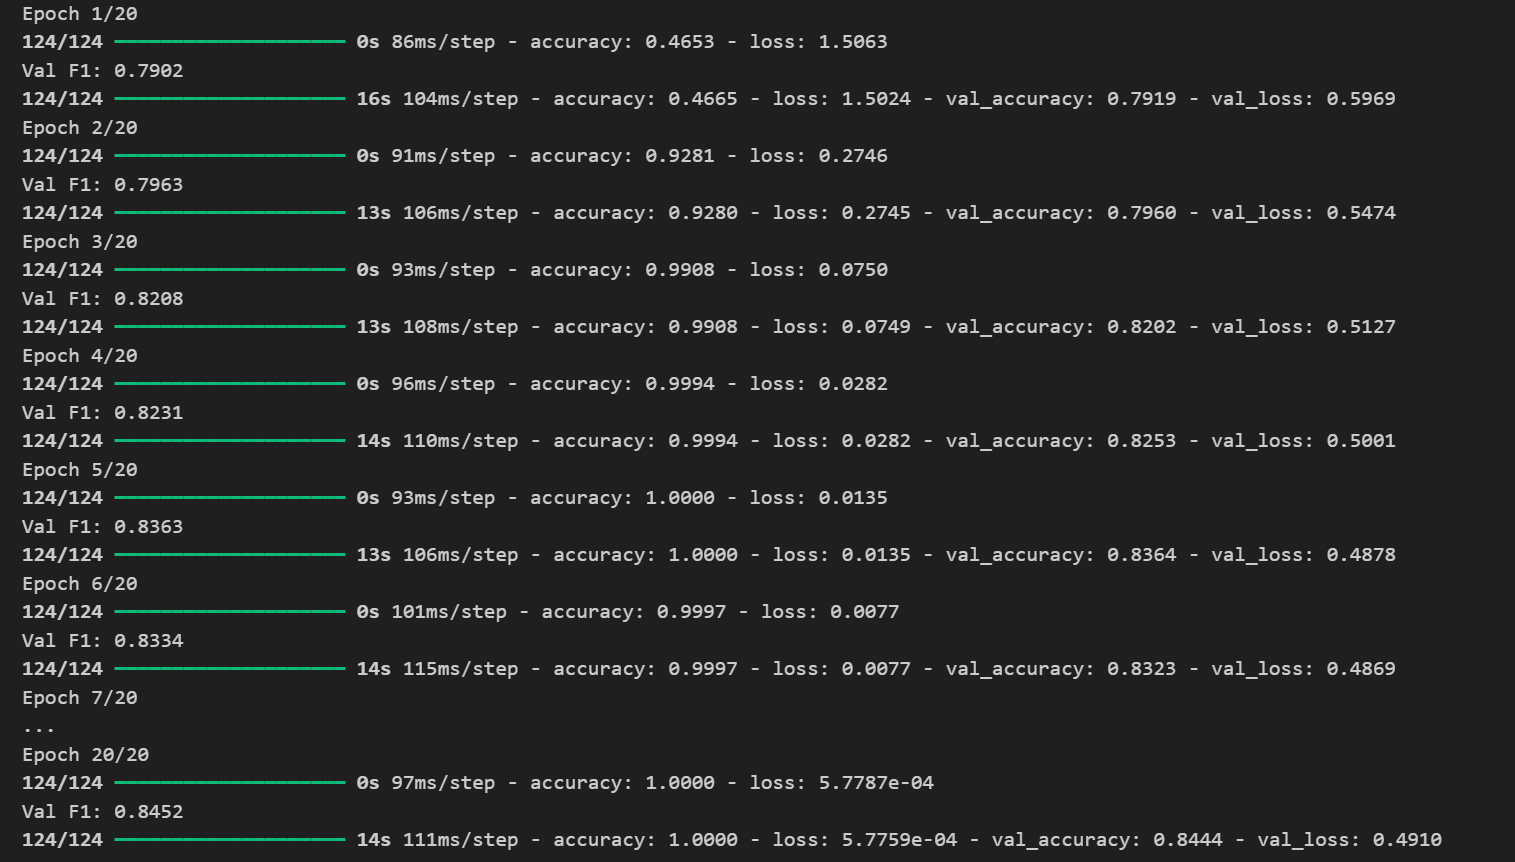
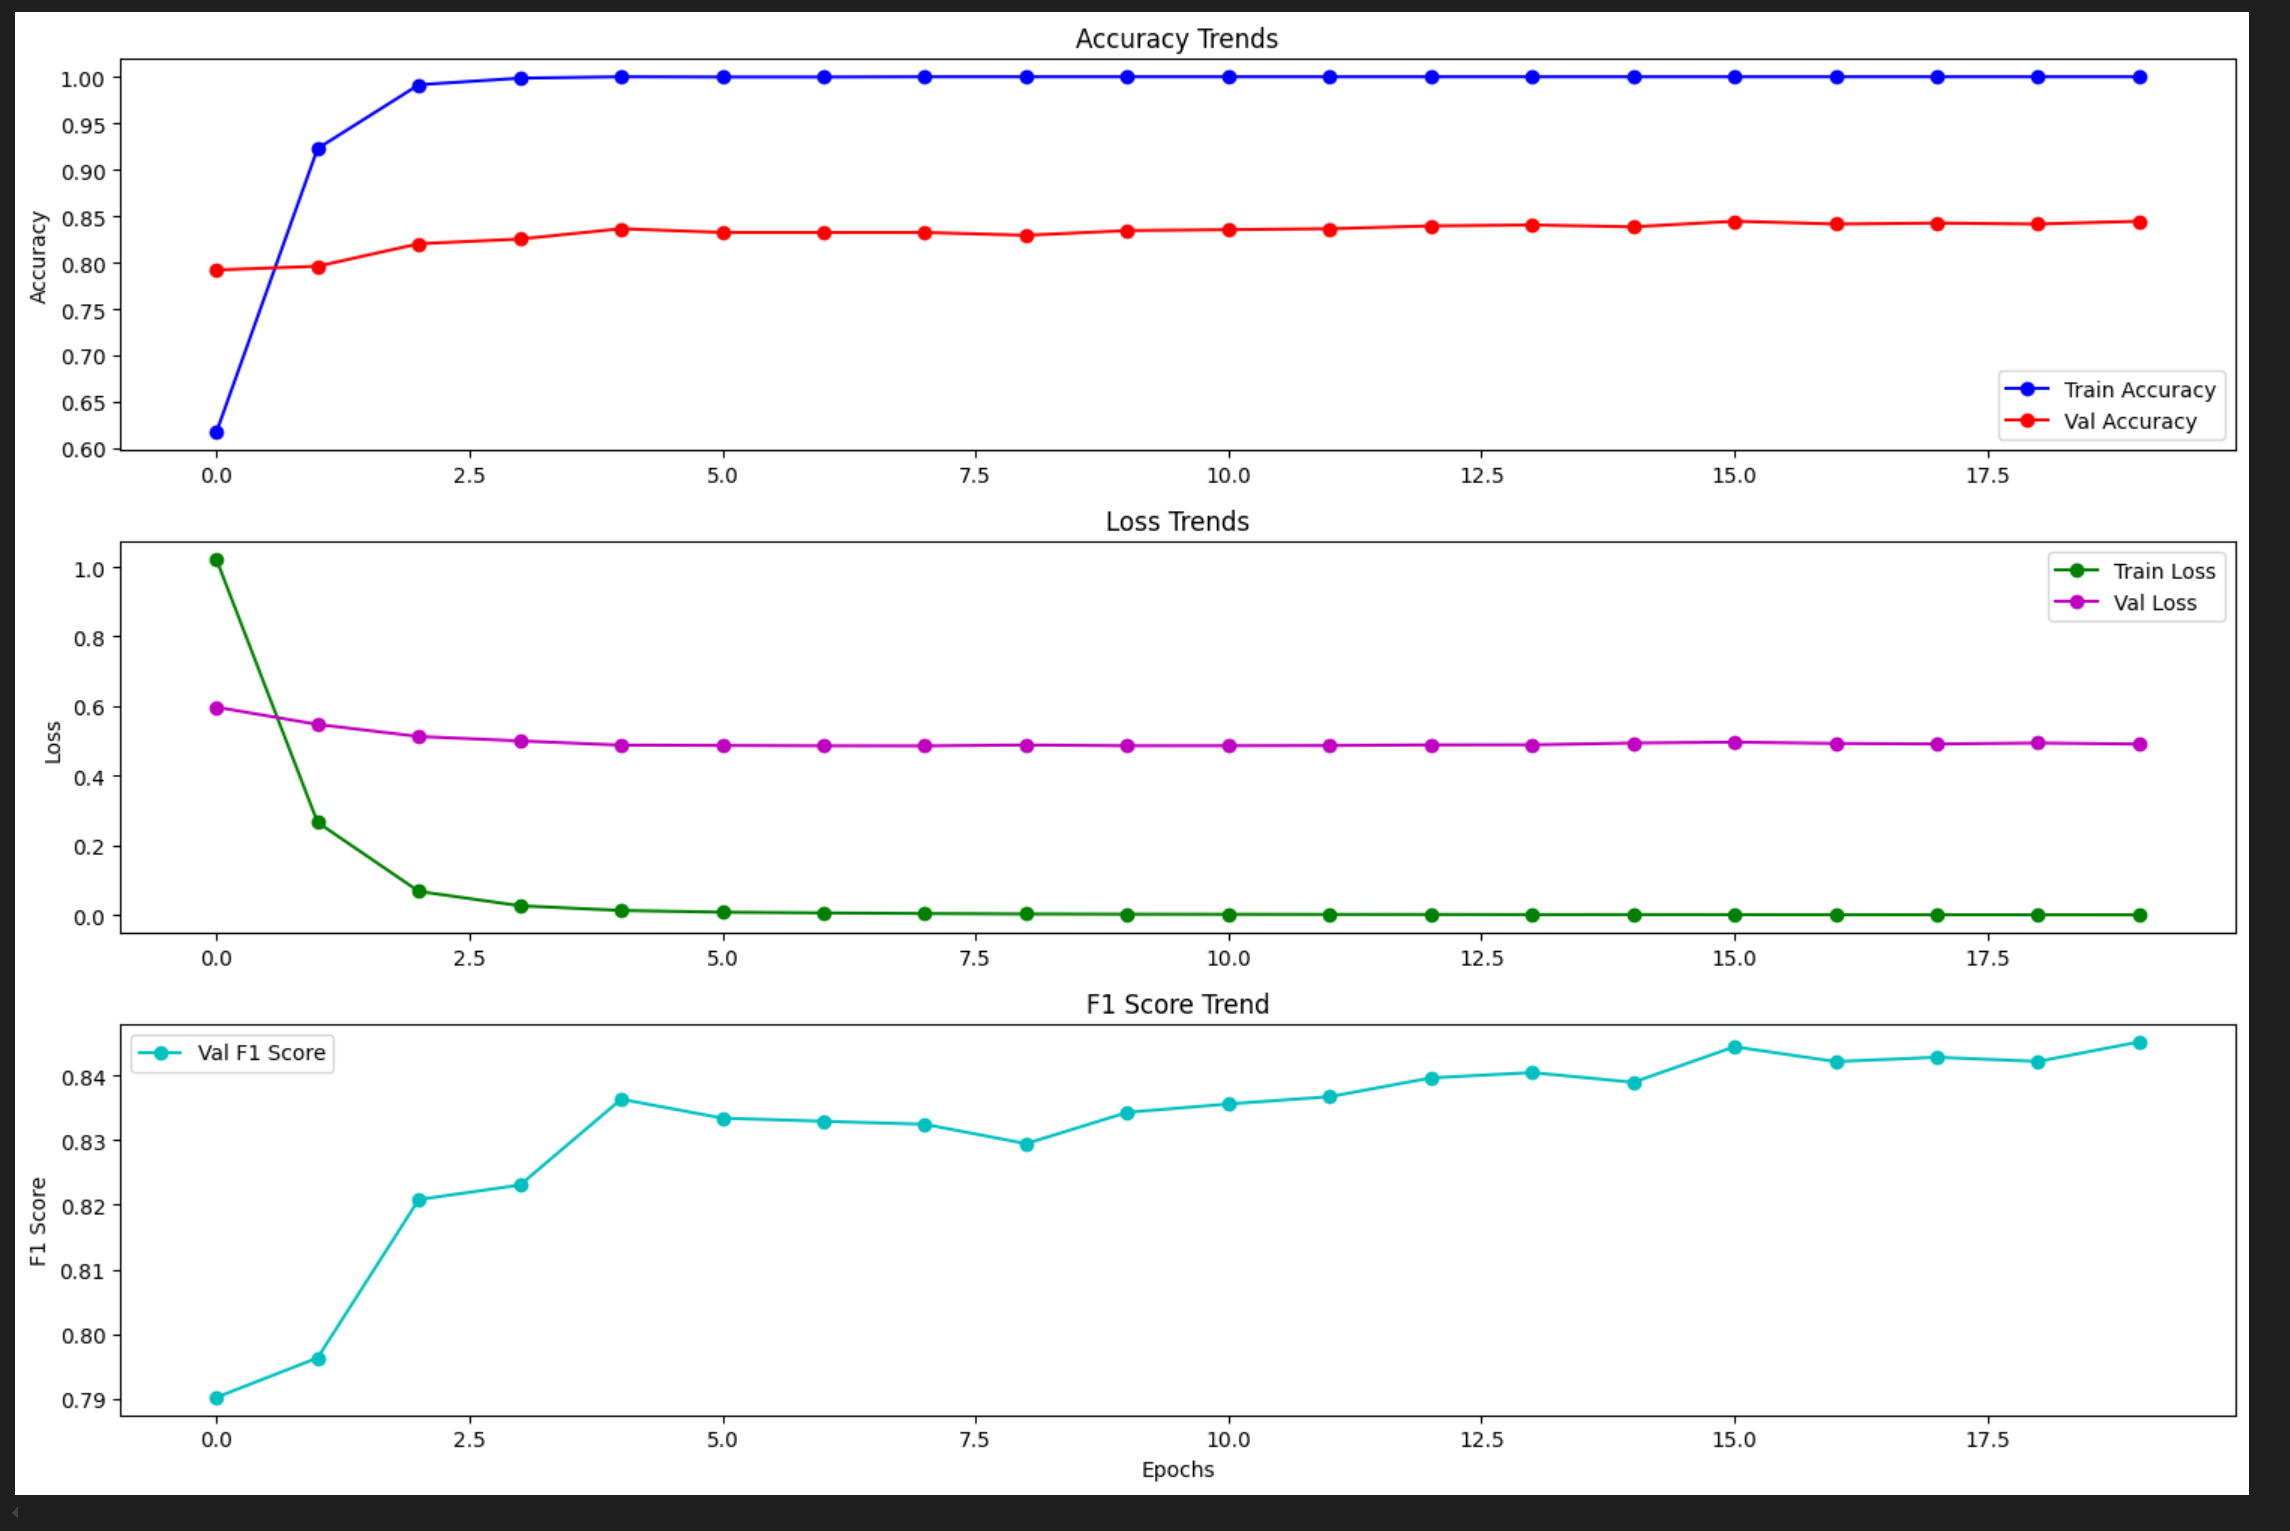

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, MultiHeadAttention, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
import re
import matplotlib.pyplot as plt
from collections import Counter

# 1. 데이터 불러오기 및 컬럼명 정리
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_df = test_df.rename(columns={'text': 'conversation', 'idx': 'file_name'})

# 2. 텍스트 전처리 및 클래스명 통일
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text).strip())
    return text

def clean_class(x):
    return x.replace(' ', '').replace('대화', '')

train_df['conversation'] = train_df['conversation'].apply(clean_text)
test_df['conversation'] = test_df['conversation'].apply(clean_text)
train_df['class'] = train_df['class'].apply(clean_class)

# 3. 클래스 매핑
custom_classes = ['협박', '갈취', '직장내괴롭힘', '기타괴롭힘', '일반']
class2idx = {c: i for i, c in enumerate(custom_classes)}
idx2class = {i: c for i, c in enumerate(custom_classes)}
train_df['target'] = train_df['class'].map(class2idx)

# 4. 특수 토큰 추가
train_df['conversation'] = "[CLS] " + train_df['conversation'].astype(str) + " [SEP]"
test_df['conversation'] = "[CLS] " + test_df['conversation'].astype(str) + " [SEP]"

# 5. 데이터 분할
X = train_df['conversation'].values.astype(str)
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. 하이퍼파라미터
VOCAB_SIZE = 20000
MAX_LEN = 128
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
BATCH_SIZE = 32

# 7. 텍스트 벡터화
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)
vectorize_layer.adapt(X_train)

# 8. 트랜스포머 인코더 정의
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(0.3)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    y = Dense(ff_dim, activation="relu")(x)
    y = Dense(inputs.shape[-1])(y)
    y = Dropout(0.3)(y)
    return LayerNormalization(epsilon=1e-6)(x + y)

# 9. 모델 구성 (입력 shape=(), 텐서 1D)
inputs = Input(shape=(), dtype=tf.string)
x = vectorize_layer(inputs)
x = Embedding(VOCAB_SIZE, EMBED_DIM)(x)
x = transformer_encoder(x, head_size=EMBED_DIM//NUM_HEADS, num_heads=NUM_HEADS, ff_dim=FF_DIM)
x = GlobalMaxPool1D()(x)
outputs = Dense(len(custom_classes), activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 10. F1-score 콜백 정의
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_val_tensor, verbose=0).argmax(axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        self.f1_scores.append(f1)
        print(f'\nVal F1: {f1:.4f}')

f1_callback = F1Callback()

# 11. 텐서 변환 (1D로 변환)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.string)

# 12. 모델 학습
history = model.fit(
    X_train_tensor, y_train,
    validation_data=(X_val_tensor, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[f1_callback]
)

# 13. 학습 결과 그래프 출력
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(epochs, history.history['loss'], 'go-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(epochs, f1_callback.f1_scores, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 14. 검증 데이터 F1 Score
print("\n[Validation F1 Score 계산]")
y_val_pred = model.predict(X_val_tensor).argmax(axis=1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f"Validation F1 Score (Macro): {val_f1:.4f}")

# 15. 테스트 데이터 예측 및 제출 파일 생성
print("\n[테스트 데이터 예측]")
X_test = test_df['conversation'].values.astype(str)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.string)
y_pred = model.predict(X_test_tensor).argmax(axis=1)

# 예측 결과 분포 확인
print("\n예측 클래스 분포:")
class_names = [idx2class[i] for i in y_pred]
print(Counter(class_names))

# 제출 파일 생성 (숫자 target, 컬럼명 idx/target)
submission_4 = pd.DataFrame({
    'idx': test_df['file_name'],
    'target': y_pred
})
submission_4.to_csv('submission_4.csv', index=False)


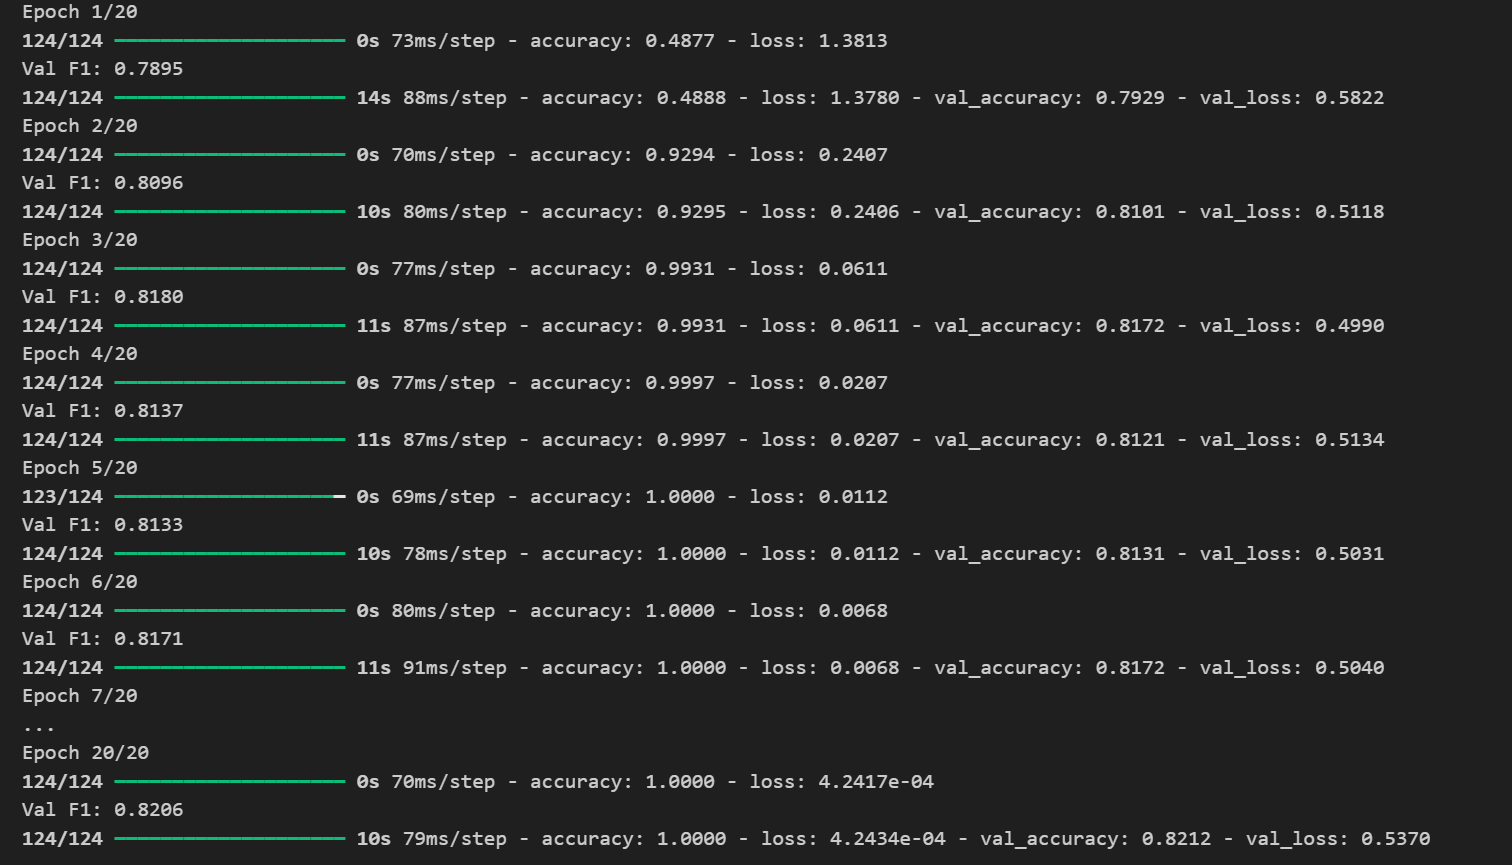
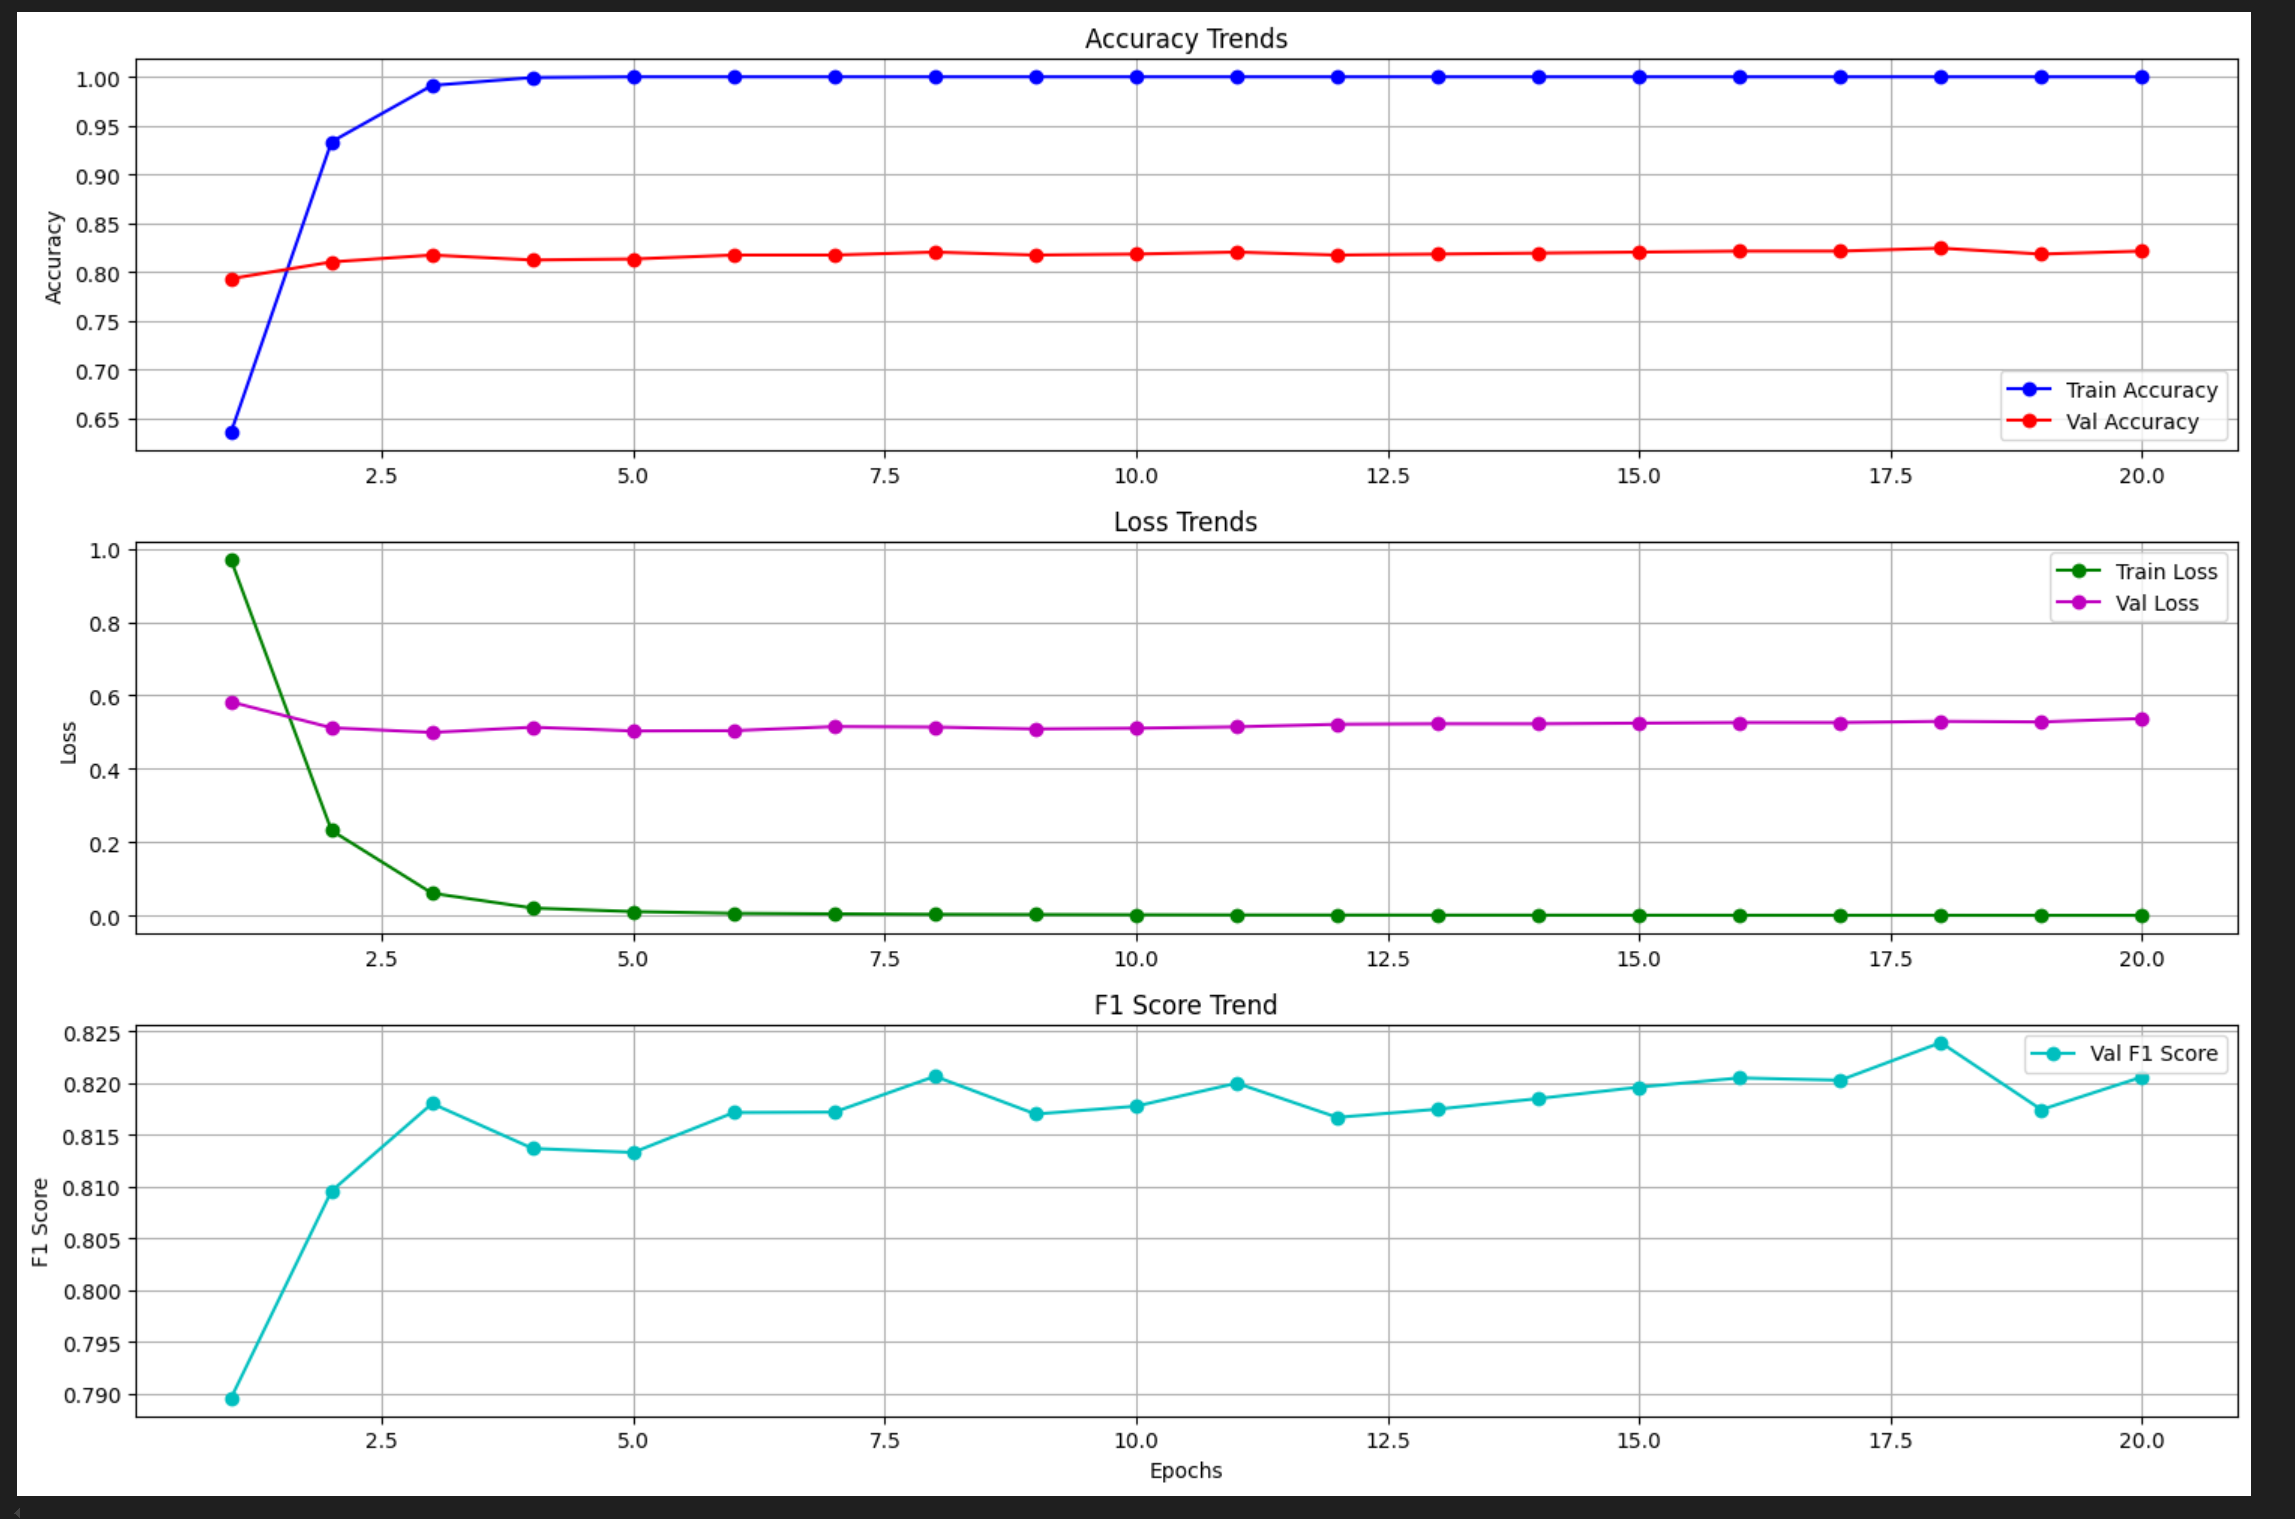
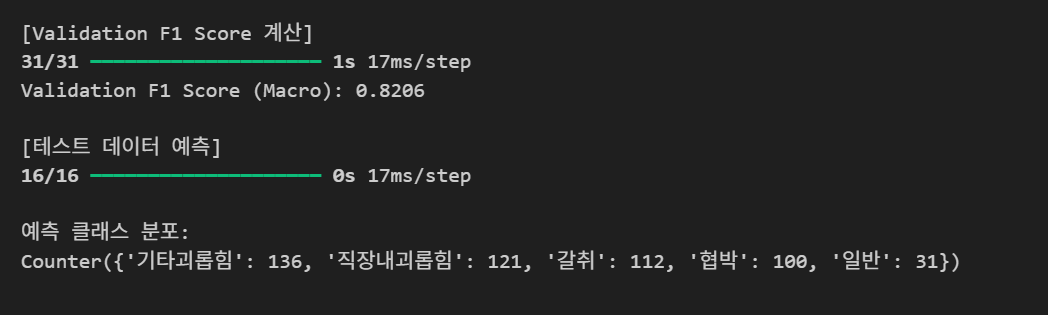

트랜스포머(Transformer) 인코더 기반의 텍스트 분류 모델

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 데이터 준비
url = 'https://raw.githubusercontent.com/bbeomdev/DLThon/main/hyunjin/train_merged.csv'
df = pd.read_csv(url)
#제출시 변환 필요요
#df = pd.read_csv('submission.csv')
#df = df.rename(columns={'file_name': 'idx','class': 'target'})

# 데이터 셔플(선택사항)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled['idx'] = range(len(df_shuffled))

# 레이블 인코딩
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# 데이터 분할
X = df['conversation'].values.astype(str)
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val = tf.convert_to_tensor(X_val, dtype=tf.string)

# 텍스트 벡터화
VOCAB_SIZE = 20000
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=128
)
vectorize_layer.adapt(X_train)

# 트랜스포머 인코더 정의
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128):
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    y = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    y = tf.keras.layers.Dense(inputs.shape[-1])(y)
    y = tf.keras.layers.Dropout(0.3)(y)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + y)

# 모델 구성
inputs = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
x = tf.keras.layers.Embedding(VOCAB_SIZE, 128)(x)
x = transformer_encoder(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(len(le.classes_), activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# F1-score 콜백 정의
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_val, verbose=0).argmax(axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        self.f1_scores.append(f1)
        print(f'\nVal F1: {f1:.4f}')

# 콜백 인스턴스 생성
f1_callback = F1Callback()

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[f1_callback]
)

# 결과 추출
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_f1 = f1_callback.f1_scores

# 그래프 출력
plt.figure(figsize=(15, 10))

# 1. 정확도(Accuracy) 그래프
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. 손실(Loss) 그래프
plt.subplot(3, 1, 2)
plt.plot(epochs, train_loss, 'go-', label='Train Loss')
plt.plot(epochs, val_loss, 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. F1 스코어 그래프
plt.subplot(3, 1, 3)
plt.plot(epochs, val_f1, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

트랜스포머(Transformer) 기반의 텍스트 분류 모델

In [2]:
import pandas as pd
import numpy as np
import math  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalMaxPool1D, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt

# 1. 데이터 준비
df = pd.read_csv('submission.csv')
df = df.rename(columns={'file_name': 'idx','class': 'target'})

# 레이블 인코딩
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# 데이터 분할
X = df['conversation'].astype(str).values
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. 텍스트 벡터화
VOCAB_SIZE = 20000
MAX_LEN = 128

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)
vectorize_layer.adapt(X_train)

# 3. 포지셔널 인코딩 클래스
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)

    def get_angles(self, position, i, embed_dim):
        angles = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        return position * angles

    def positional_encoding(self, max_len, embed_dim):
        angle_rads = self.get_angles(
            position=tf.range(max_len, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
            embed_dim=embed_dim
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

# 4. 트랜스포머 디코더 블록
class TransformerDecoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(num_heads, embed_dim)
        self.enc_attn = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def call(self, inputs, enc_output, training=False):
        attn1 = self.self_attn(inputs, inputs, use_causal_mask=True)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(inputs + attn1)
        
        attn2 = self.enc_attn(out1, enc_output)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

# 5. 모델 구성 함수
def build_transformer_model():
    inputs = Input(shape=(1,), dtype=tf.string)
    
    # 벡터화
    x = vectorize_layer(inputs)
    x = Embedding(VOCAB_SIZE, 128)(x)
    x = PositionalEncoding(MAX_LEN, 128)(x)
    
    # 인코더
    enc_output = None
    for _ in range(2):
        x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = Dropout(0.3)(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(128)(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        enc_output = x
    
    # 디코더
    dec_input = x
    for _ in range(2):
        dec_input = TransformerDecoderBlock(128, 4, 256)(dec_input, enc_output)
    
    # 출력
    x = GlobalMaxPool1D()(dec_input)
    outputs = Dense(len(le.classes_), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# 6. 모델 생성
model = build_transformer_model()



# 7. 학습 실행
X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val = tf.convert_to_tensor(X_val, dtype=tf.string)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

# F1-score 콜백 정의
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_val, verbose=0).argmax(axis=1)
        f1 = f1_score(y_val, y_pred, average='macro')
        self.f1_scores.append(f1)
        print(f'\nVal F1: {f1:.4f}')

# 콜백 인스턴스 생성
f1_callback = F1Callback()

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[f1_callback]
)

# 결과 추출
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_f1 = f1_callback.f1_scores

# 그래프 출력
plt.figure(figsize=(15, 10))

# 1. 정확도(Accuracy) 그래프
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
plt.title('Accuracy Trends')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. 손실(Loss) 그래프
plt.subplot(3, 1, 2)
plt.plot(epochs, train_loss, 'go-', label='Train Loss')
plt.plot(epochs, val_loss, 'mo-', label='Val Loss')
plt.title('Loss Trends')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. F1 스코어 그래프
plt.subplot(3, 1, 3)
plt.plot(epochs, val_f1, 'co-', label='Val F1 Score')
plt.title('F1 Score Trend')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'